<h1><center>Проект Временные ряды</center></h1>

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.


2. Проанализируйте данные.


3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.


4. Проверьте данные на тестовой выборке и сделайте выводы.

# Описание данных

Данные лежат в файле /datasets/taxi.csv.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# Содержание

1. Загрузка и ресемплирование данных


2. Анализ моделей


3. Обучение моделей

    3.1 Подготовка признаков
    
    3.2 Обучение модели линейной регресии
    
    3.3 Обучение модели случайный лес 
    
    3.4 Обучение модели градиентного бустинга
    
    3.5 Итоги обучения моделей


4. Проверка моделей на тестовый данных

# Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import warnings
import time

import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

# Параметры псевдослучайной генерации

In [2]:
RANDOM_STATE = 12345

# Функции

In [3]:
def info_head(df, rows=5):
    df.info()
    display(df.head(rows))
    
    
def plot_columns(df, title):
    ncols = len(df.columns)
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 4))

    for i in range(ncols):
        column = df.columns[i]
        sns.distplot(df[column], ax=ax[i])
        ax[i].set_xlabel(column)
        

    fig.tight_layout()
    fig.suptitle(title, fontsize=16,  y=1.1)

    plt.show()
    
    
def date_features(df):

    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    return df


def rolling_mean_feature(df, rolling_mean_size):
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df


def lag_features(df, max_lag):
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    return df


def create_features(df, rolling_mean_size, max_lag):
    
    df = date_features(df)
    df = rolling_mean_feature(df, rolling_mean_size)
    df = lag_features(df, max_lag)
    
    df = df.dropna()
    
    X_df = df.drop(['num_orders'], axis=1)

    y_df = df['num_orders']
    
    return X_df, y_df


def blocking_split(X, n_splits):
    n_samples = len(X)
    k_fold_size = n_samples // n_splits
    indices = np.arange(n_samples)

    for i in range(n_splits):
        start = i * k_fold_size
        stop = start + k_fold_size
        mid = int(0.8 * (stop - start)) + start
        yield indices[start: mid], indices[mid: stop]
        
        
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5


def learing_results(model, params, X_train, y_train, X_test, y_test):

    model.set_params(**params)
    
    # Fitting model
    model.fit(X_train, y_train)

    # -------------------------------     

    # Prediction
    predict = model.predict(X_test)

    # -------------------------------     

    # RMSE metric
    metric_rmse = int(rmse(y_test, predict))
    
    # R2 metric
    metric_r2 = round(r2_score(y_test, predict), 2)
    
    # -------------------------------     
    
    # Get model name
    model_name = type(model).__name__
    
    columns = ['Метрика RMSE', 'Метрика R2']
    
    data = [metric_rmse, metric_r2]
    
    return pd.DataFrame([data], columns=columns, index=[model_name])

# 1. Загрузка и ресемплирование данных

In [4]:
taxi_raw = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [5]:
info_head(taxi_raw)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


- Пропусков не обнаружено


- Отсортируем данные по дате и проведем ресамплинг на 1 час

In [6]:
taxi_raw.sort_index(inplace=True)

taxi_1h = taxi_raw.resample('1H').sum().astype('int64')

In [7]:
info_head(taxi_1h)

print('\nКоличество данных после ресамплинга уменьшилось в {:.0f} раз'.format(len(taxi_raw)/len(taxi_1h)))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Количество данных после ресамплинга уменьшилось в 6 раз


- После ресамплинга в 1 час данных стало в 6 раз меньше

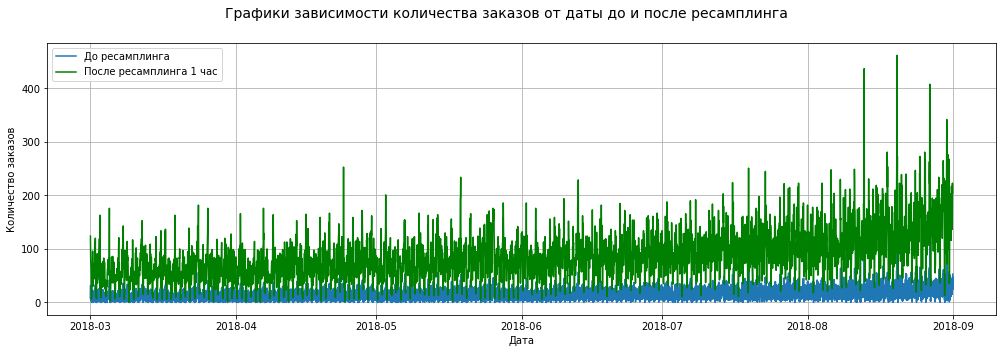

In [8]:
fig, ax = plt.subplots(figsize=(17, 5))

sns.lineplot(x=taxi_raw.index, y=taxi_raw['num_orders'], ax=ax, label='До ресамплинга')
sns.lineplot(x=taxi_1h.index, y=taxi_1h['num_orders'], ax=ax, label='После ресамплинга 1 час', color='green')

ax.set(xlabel='Дата', ylabel='Количество заказов')
ax.grid()

fig.suptitle('Графики зависимости количества заказов от даты до и после ресамплинга', fontsize=14)

plt.legend()

plt.show()

# 2. Анализ данных

-  Попробуем выделить тренд и сезонную составляющую

In [9]:
taxi_decomposed = seasonal_decompose(taxi_1h)

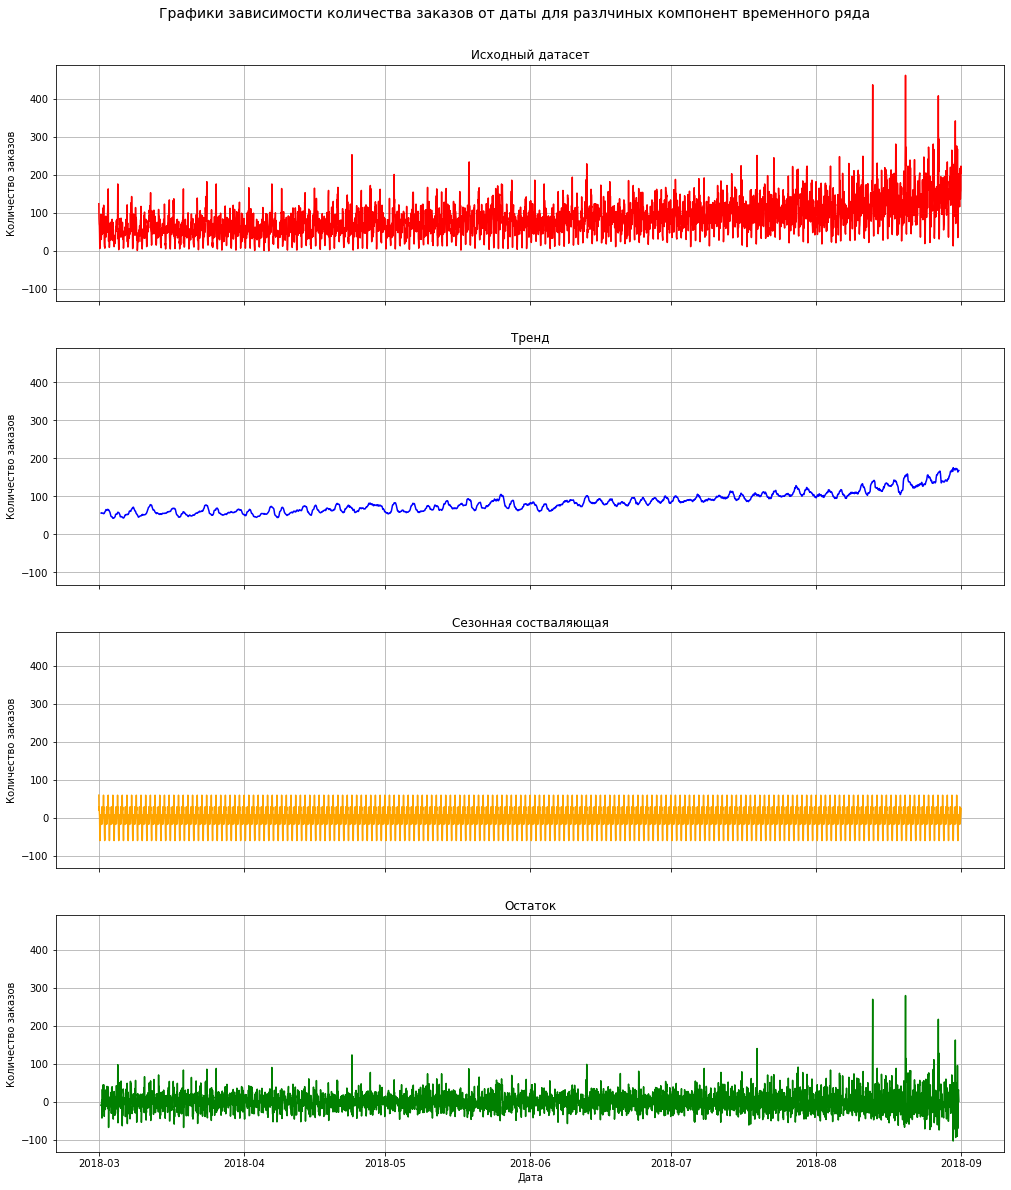

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(17, 20), sharey=True, sharex=True)

fig.suptitle('Графики зависимости количества заказов от даты для разлчиных компонент временного ряда', fontsize=14, y=0.92)

sns.lineplot(x=taxi_1h.index, y=taxi_decomposed.observed, ax=ax[0], color='red')
sns.lineplot(x=taxi_1h.index, y=taxi_decomposed.trend, ax=ax[1], color='blue')
sns.lineplot(x=taxi_1h.index, y=taxi_decomposed.seasonal, ax=ax[2], color='orange')
sns.lineplot(x=taxi_1h.index, y=taxi_decomposed.resid, ax=ax[3], color='green')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set(ylabel='Количество заказов')
ax[1].set(ylabel='Количество заказов')
ax[2].set(ylabel='Количество заказов')
ax[3].set(xlabel='Дата', ylabel='Количество заказов')

ax[0].set_title('Исходный датасет')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонная состваляющая')
ax[3].set_title('Остаток')

plt.show()

- Оценим амплиутдно частотные спектры разных компонент временного ряда

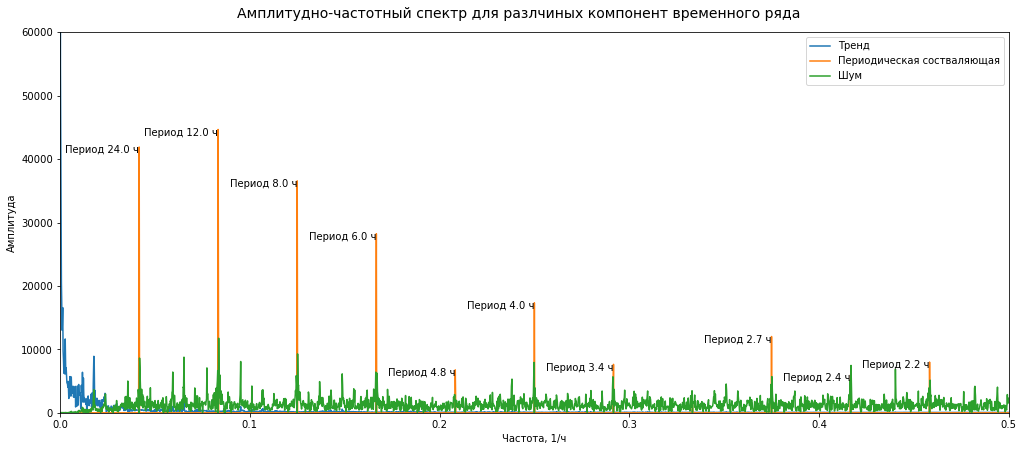

In [11]:
S_trend = np.abs(fft(taxi_decomposed.trend.iloc[12:-12].values))
S_seasonal = np.abs(fft(taxi_decomposed.seasonal.iloc[12:-12].values))
S_resid = np.abs(fft(taxi_decomposed.resid.iloc[12:-12].values))

i_max = len(S_trend)//2
freq_max = 1/2
freq_step = freq_max/i_max
frequency = [round(x*freq_step, 4) for x in range(0, i_max)]

f, ax = plt.subplots(figsize=(17,7))

f.suptitle('Амплитудно-частотный спектр для разлчиных компонент временного ряда', fontsize=14, y=0.93)

sns.lineplot(x=frequency, y=S_trend[0:i_max], ax=ax, label='Тренд')
sns.lineplot(x=frequency, y=S_seasonal[0:i_max], ax=ax, label='Периодическая состваляющая')
sns.lineplot(x=frequency, y=S_resid[0:i_max], ax=ax, label='Шум')
plt.ylim(0, 60000)
plt.xlim(0, freq_max)


S_seasonal_max_xy=[]
for i in range(i_max):
    if S_seasonal[i] > 5000:
        S_seasonal_max_xy.append([frequency[i], S_seasonal[i]])

for xy in S_seasonal_max_xy: 
    ax.annotate('Период '+str(round(1/xy[0],1))+' ч',
                xy=(xy[0], xy[1]), xycoords='data',
                xytext=(xy[0], xy[1]+300), textcoords='data',
                horizontalalignment='right', verticalalignment='top')

ax.set(xlabel='Частота, 1/ч', ylabel='Амплитуда')    

plt.show()

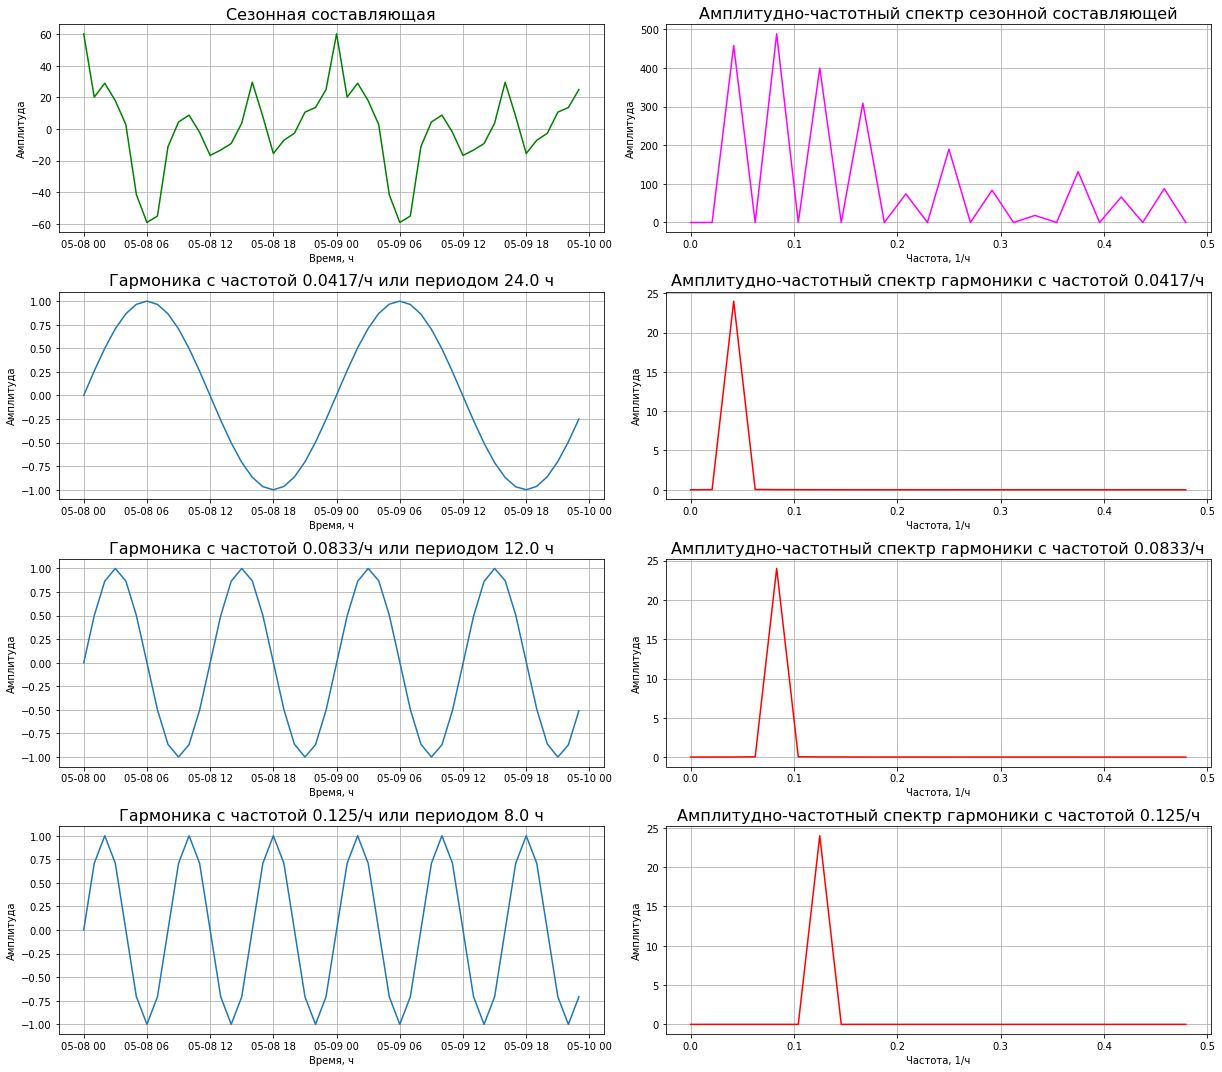

In [12]:
func=taxi_decomposed.seasonal['2018-05-08':'2018-05-9']

S_func = np.abs(fft(func.values))

i_max = len(S_func)//2
freq_max = 1/2
freq_step = freq_max/i_max
frequency = [round(x*freq_step, 4) for x in range(0, i_max)]

S_func_max_xy=[]
for i in range(i_max):
    if S_func[i] > 100:
        S_func_max_xy.append([frequency[i], S_func[i]])



fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(17,15), sharey=False, sharex=False)

sns.lineplot(x=func.index, y=func, ax=ax[0][0], color='green')
sns.lineplot(x=frequency, y=S_func[0:i_max], ax=ax[0][1], color='magenta')

ax[0][0].set(xlabel='Время, ч', ylabel='Амплитуда')    
ax[0][1].set(xlabel='Частота, 1/ч', ylabel='Амплитуда')    


ax[0][0].grid()
ax[0][1].grid()

    
    
time = np.arange(len(func))
for i in range(3):
    
    f = S_func_max_xy[i][0]
    sin_func = np.sin(2*np.pi *f * time)
    S_sin_func = np.abs(fft(sin_func))

    sns.lineplot(x=func.index, y=sin_func, ax=ax[i+1][0])
    sns.lineplot(x=frequency, y=S_sin_func[0:i_max], ax=ax[i+1][1], color='red')
    
    ax[i+1][0].set(xlabel='Время, ч', ylabel='Амплитуда')    
    ax[i+1][1].set(xlabel='Частота, 1/ч', ylabel='Амплитуда')   
    
    ax[i+1][0].set_title('Гармоника с частотой '+str(S_func_max_xy[i][0])+'/ч или периодом '+str(round(1/S_func_max_xy[i][0],0))+' ч', fontsize=16)
    ax[i+1][1].set_title('Амплитудно-частотный спектр гармоники с частотой '+str(S_func_max_xy[i][0])+'/ч', fontsize=16)   

    ax[i+1][0].grid()
    ax[i+1][1].grid()

    
    
ax[0][0].set_title('Сезонная составляющая', fontsize=16)
ax[0][1].set_title('Амплитудно-частотный спектр сезонной составляющей', fontsize=16)

    
fig.tight_layout()
plt.show()

- На графике амплитудно частотного спектра явным образом выделятся:


    1. Нулевая и околонулевая частота тренда - некоторая постоянная составляющая
        
    2. Выраженные максимумы спектра периодической составляющей. Минимальный период составляет 2.2 часа, максимальный - 24 часа. 
        
    3. Небольшимими случайными флуктуациями представлена шумовая составляющая в частотной области

- Выделенный тренд осложнен низкочастотными помехами, попробуем их отфильровать


- Фильтр размером 200 точек позволит отфильтровать все частоты выше 0.005/ч

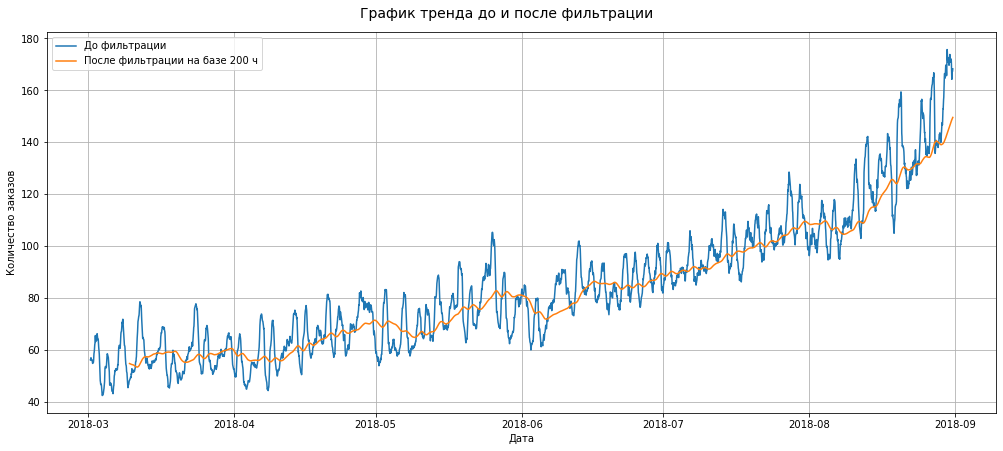

In [13]:
f, ax = plt.subplots(figsize=(17,7))

f.suptitle('График тренда до и после фильтрации', fontsize=14, y=0.93)

sns.lineplot(x=taxi_1h.index, y=taxi_decomposed.trend, ax=ax, label='До фильтрации')

sns.lineplot(x=taxi_1h.index, y=taxi_decomposed.trend.rolling(200).mean(), ax=ax, label='После фильтрации на базе 200 ч')

ax.set(xlabel='Дата', ylabel='Количество заказов')    
ax.grid()
plt.legend()

plt.show()

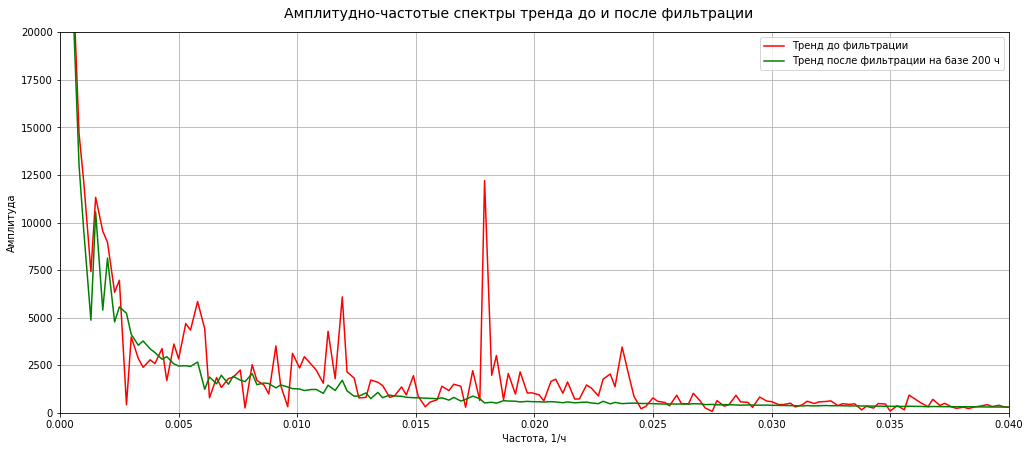

In [14]:
S_trend = np.abs(fft(taxi_decomposed.trend.iloc[225:-225].values))
S_trend_mean = np.abs(fft(taxi_decomposed.trend.rolling(200).mean().iloc[225:-225].values))

i_max = len(S_trend)//2
freq_max = 1/2
freq_step = freq_max/i_max
frequency = [round(x*freq_step, 4) for x in range(0, i_max)]

f, ax = plt.subplots(figsize=(17,7))

f.suptitle('Амплитудно-частотые спектры тренда до и после фильтрации', fontsize=14, y=0.93)

sns.lineplot(x=frequency, y=S_trend[0:i_max], ax=ax, label='Тренд до фильтрации', color='red')
sns.lineplot(x=frequency, y=S_trend_mean[0:i_max], ax=ax, label='Тренд после фильтрации на базе 200 ч', color='green')
plt.ylim(0, 20000)
plt.xlim(0, 0.04)

ax.set(xlabel='Частота, 1/ч', ylabel='Амплитуда')    
ax.grid()

plt.show()

- На спектрах видно, что после фильтрации на базе 200 ч в тренде практически не осталось побочных максимумов и полностью преобладает нулевая частота

# 3. Обучение моделей

## 3.1 Подготовка признаков

- Разделим выборки на обучающую и тестовую в соотношении 90:10

In [15]:
train, test = train_test_split(taxi_1h, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)

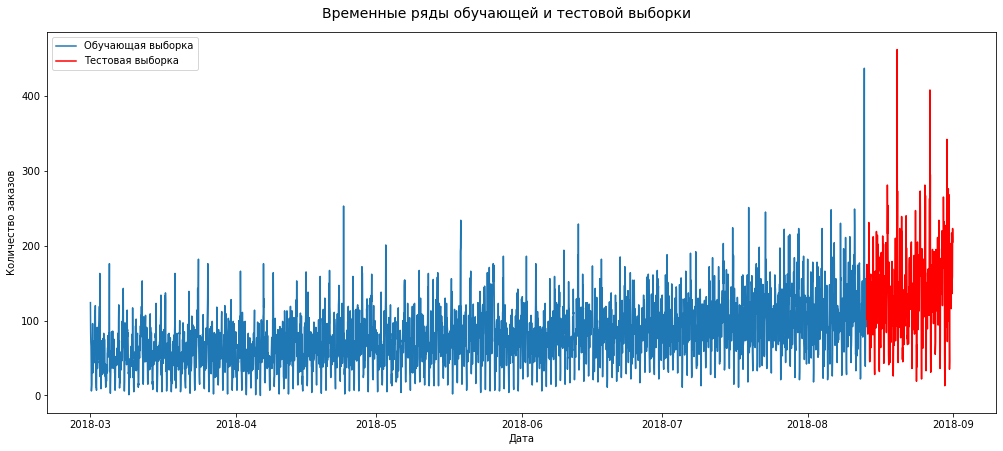

In [16]:
f, ax = plt.subplots(figsize=(17,7))

f.suptitle('Временные ряды обучающей и тестовой выборки', fontsize=14, y=0.93)

sns.lineplot(x=train.index, y=train['num_orders'], ax=ax, label='Обучающая выборка')
sns.lineplot(x=test.index, y=test['num_orders'], ax=ax, label='Тестовая выборка', color='red')

ax.set(xlabel='Дата', ylabel='Количество заказов')    

plt.show()

- Создадим признаки

1. Календарные признаки

In [17]:
warnings.filterwarnings('ignore')

train['dayofweek'] = train.index.dayofweek
train['hour'] = train.index.hour

display(train.head())

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


2. Скользящее среднее

In [18]:
rolling_mean_size = 200

train['rolling_mean'] = train['num_orders'].shift().rolling(rolling_mean_size).mean()

display(train.tail())

,num_orders,dayofweek,hour,rolling_mean
datetime,,,,
2018-08-13 09:00:00,137,0,9,111.980
2018-08-13 10:00:00,156,0,10,112.095
2018-08-13 11:00:00,144,0,11,112.140
2018-08-13 12:00:00,92,0,12,112.265
2018-08-13 13:00:00,119,0,13,112.115


3. Отстающие значения

- Максимальный период событий составляет 24 часа, минимальный - 2.2 часа. Чтобы выделить события с периодом $N$ необходимо взять окно размером $1/(2N)$. Таким образом минимальный лаг остающих значений будет равен 1 часу, максимальный - 12 часов

In [19]:
max_lag = 12

for lag in range(1, max_lag + 1):
    train['lag_{}'.format(lag)] = train['num_orders'].shift(lag)
    
display(train.iloc[250:255])

,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,
2018-03-11 10:00:00,56,6,10,52.000,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0,73.0,80.0
2018-03-11 11:00:00,51,6,11,52.155,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0,73.0
2018-03-11 12:00:00,50,6,12,52.090,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0,81.0
2018-03-11 13:00:00,80,6,13,52.120,50.0,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0,83.0
2018-03-11 14:00:00,72,6,14,52.445,80.0,50.0,51.0,56.0,66.0,43.0,14.0,16.0,11.0,30.0,49.0,36.0


- Выделим целевой и обучающие признаки

In [20]:
X_train = train.drop(['num_orders'], axis=1)

y_train = train['num_orders']

In [21]:
info_head(X_train)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dayofweek     3974 non-null   int64  
 1   hour          3974 non-null   int64  
 2   rolling_mean  3774 non-null   float64
 3   lag_1         3973 non-null   float64
 4   lag_2         3972 non-null   float64
 5   lag_3         3971 non-null   float64
 6   lag_4         3970 non-null   float64
 7   lag_5         3969 non-null   float64
 8   lag_6         3968 non-null   float64
 9   lag_7         3967 non-null   float64
 10  lag_8         3966 non-null   float64
 11  lag_9         3965 non-null   float64
 12  lag_10        3964 non-null   float64
 13  lag_11        3963 non-null   float64
 14  lag_12        3962 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 496.8 KB


,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,3,1,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,3,2,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,3,3,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,3,4,NaN,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
display(y_train)

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3974, dtype: int64

- Итоговая подготовка признаков:

In [23]:
rolling_mean_size = 200

max_lag = 12

X_train, y_train = create_features(train, rolling_mean_size, max_lag)

## 3.2 Обучение модели линейной регресии

- Обычную кросс-валидацию для обучения временных рядов использовать мы не можем, т.к. последовательность значений в обучающей и валидационной выборке должна оставаться упорядоченной


- Воспользуемся алгортимом блоковой кросс-валидации:
    1. Разделим выборку на $N$ последовательных блоков
    2. В каждом блоке первые 80% данных будут использоваться для обучения, остальные 20% - для валидации

In [24]:
cv = blocking_split(X_train, 5)

- Для оценки качества будем использовать метрику RMSE и дополнительно R2

In [25]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

- Зададим модель

In [26]:
estimator = LinearRegression()

- Определим параметры для тестирования

In [27]:
param_grid = {
    'fit_intercept' : [True, False],
    'normalize' : [True, False]
}

- Зададим параметры сетки подбора модели

In [28]:
model_linear_regression = GridSearchCV(estimator, param_grid, cv=cv, scoring=rmse_scorer)

- Обучим модели на сетке параметров

In [29]:
%%time
model_linear_regression.fit(X_train, y_train)

Wall time: 82 ms


GridSearchCV(cv=<generator object blocking_split at 0x000001CE98374270>,
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(rmse, greater_is_better=False))

- Оценим характеристики лучшей модели

In [30]:
params = model_linear_regression.best_params_

results_linear_regression = learing_results(estimator, params, X_train, y_train, X_train, y_train)

display(results_linear_regression)

,Метрика RMSE,Метрика R2
LinearRegression,30,0.39


## 3.3 Обучение модели случайный лес

- Зададим модель

In [31]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)

- Зададим кросс-валидацию

In [32]:
cv = blocking_split(X_train, 5)

- Определим параметры для тестирования

In [33]:
param_grid = {
    'n_estimators' : [100, 150, 200],
    'max_depth' : range(1, 10, 2),
    'min_samples_split' : range(2, 10, 2),
    'max_features' : ['auto', 'sqrt', 'log2']
}

- Зададим параметры сетки подбора модели

In [34]:
model_random_forest = GridSearchCV(estimator, param_grid, cv=cv, scoring=rmse_scorer)

- Обучим модели на сетке параметров

In [35]:
%%time
model_random_forest.fit(X_train, y_train)

Wall time: 3min 26s


GridSearchCV(cv=<generator object blocking_split at 0x000001CE9849E120>,
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10, 2),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': [100, 150, 200]},
             scoring=make_scorer(rmse, greater_is_better=False))

- Оценим характеристики лучшей модели

In [36]:
params = model_random_forest.best_params_

results_model_random_forest = learing_results(estimator, params, X_train, y_train, X_train, y_train)

display(results_model_random_forest)

,Метрика RMSE,Метрика R2
RandomForestRegressor,16,0.82


## 3.4 Обучение модели градиентного бустинга

- Зададим модель

In [37]:
estimator = lgb.LGBMRegressor(random_state=RANDOM_STATE)

- Зададим кросс-валидацию

In [38]:
cv = blocking_split(X_train, 5)

- Определим параметры для тестирования

In [39]:
param_grid = {
    'num_leaves' : [30, 50, 70],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100]
}

- Зададим параметры сетки подбора модели

In [40]:
model_gbm = GridSearchCV(estimator, param_grid, cv=cv, scoring=rmse_scorer)

- Обучим модели на сетке параметров

In [41]:
%%time
model_gbm.fit(X_train, y_train)

Wall time: 2.05 s


GridSearchCV(cv=<generator object blocking_split at 0x000001CE98336890>,
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.01, 0.1, 1], 'n_estimators': [100],
                         'num_leaves': [30, 50, 70]},
             scoring=make_scorer(rmse, greater_is_better=False))

- Оценим характеристики лучшей модели

In [42]:
params = model_gbm.best_params_

results_gbm = learing_results(estimator, params, X_train, y_train, X_train, y_train)

display(results_gbm)

,Метрика RMSE,Метрика R2
LGBMRegressor,13,0.88


## 3.5 Итоги обучения моделей

In [43]:
display(pd.concat([results_linear_regression, results_model_random_forest, results_gbm]).sort_values(by='Метрика RMSE'))

,Метрика RMSE,Метрика R2
LGBMRegressor,13,0.88
RandomForestRegressor,16,0.82
LinearRegression,30,0.39


# 4. Проверка моделей на тестовый данных

- Подготовим признаки для тестовой выборки

- Воспользуемся значениями до тестовой выборки, чтобы заполнить значения признаков на первых отсчетах тестовой части

In [44]:
X_data, y_data = create_features(taxi_1h, rolling_mean_size, max_lag)

In [45]:
X_test = X_data.loc[test.index]
y_test = y_data.loc[test.index]

- Проведем тестирование моделей

1. Модель линейной регрессии

In [46]:
estimator = LinearRegression()

params = model_linear_regression.best_params_

test_results_linear_regression = learing_results(estimator, params, X_train, y_train, X_test, y_test)

2. Модель случайный лес

In [47]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)

params = model_random_forest.best_params_

test_results_random_forest = learing_results(estimator, params, X_train, y_train, X_test, y_test)

3. Модель градиентного бустинга

In [48]:
estimator = lgb.LGBMRegressor(random_state=RANDOM_STATE)

params = model_gbm.best_params_

test_results_gbm = learing_results(estimator, params, X_train, y_train, X_test, y_test)

- Объединим результаты в общую таблицу

In [49]:
display(pd.concat([test_results_linear_regression, test_results_random_forest, test_results_gbm]).sort_values(by='Метрика RMSE'))

,Метрика RMSE,Метрика R2
LGBMRegressor,42,0.46
RandomForestRegressor,44,0.41
LinearRegression,49,0.27


- Все модели показали достаточно хорошие значения метрики RMSE, однако модель градиентного бустинга - LGBMRegressor (GBM) дала ниалучшие значение в том числе и метрики R2

- Оценим визуально предсказания модели градиентного бустинга на тестовой выборке

In [50]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)

params = model_gbm.best_params_

model.set_params(**params)

model.fit(X_train, y_train)

predict = model.predict(X_test)

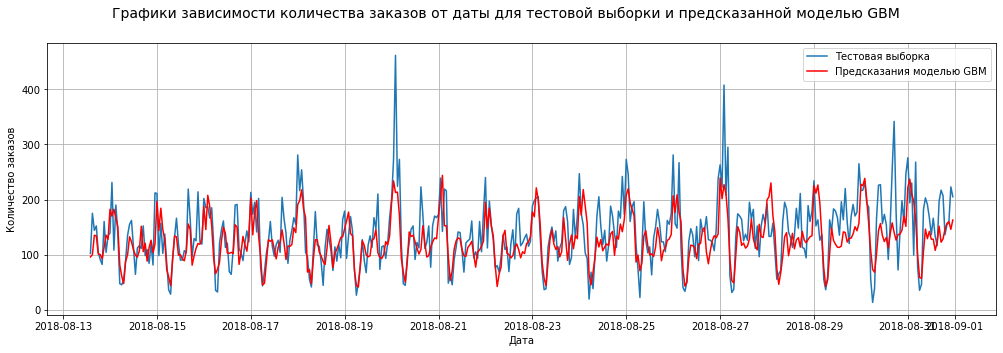

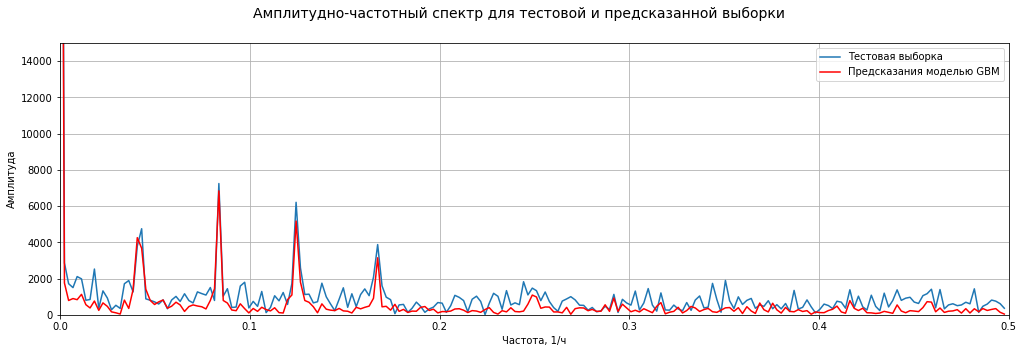

In [51]:
fig, ax = plt.subplots(figsize=(17, 5))

sns.lineplot(x=y_test.index, y=y_test, ax=ax, label='Тестовая выборка')
sns.lineplot(x=y_test.index, y=pd.Series(predict, index=y_test.index), ax=ax, label='Предсказания моделью GBM', color='red')

ax.set(xlabel='Дата', ylabel='Количество заказов')
ax.grid()

fig.suptitle('Графики зависимости количества заказов от даты для тестовой выборки и предсказанной моделью GBM', fontsize=14)

plt.legend()

plt.show()


S_test = np.abs(fft(y_test.values))
S_predict = np.abs(fft(predict))

i_max = len(S_test)//2
freq_max = 1/2
freq_step = freq_max/i_max
frequency = [round(x*freq_step, 4) for x in range(0, i_max)]

f, ax = plt.subplots(figsize=(17,5))

f.suptitle('Амплитудно-частотный спектр для тестовой и предсказанной выборки', fontsize=14)

sns.lineplot(x=frequency, y=S_test[0:i_max], ax=ax, label='Тестовая выборка')
sns.lineplot(x=frequency, y=S_predict[0:i_max], ax=ax, label='Предсказания моделью GBM', color='red')
plt.ylim(0, 15000)
plt.xlim(0, freq_max)

ax.set(xlabel='Частота, 1/ч', ylabel='Амплитуда')    
ax.grid()
plt.show()

- Визуально соответсвие между тестовыми и предсказанными данными достаточно хорошее. 


- Разумеется случайные выбросы предсказать трудно, но с основной задачей предсказания периодичных и закономерных событий модель справилась хорошо  